# Insights and Recommendations

Since the scraper tool automatically selects the top 3 restaurants on the Swiggy Bangalore frontpage, and because the restaurant listings on said page are dynamic, it may yield a different set of restaurants on re-execution. However, for the sake of consistency, I've considered the following restaurants going forward:

* [Kwality Walls Frozen Dessert and Ice Cream Shop, Btm 2nd Stage](https://www.swiggy.com/restaurants/kwality-walls-frozen-dessert-and-ice-cream-shop-btm-btm-2nd-stage-bangalore-298068)
* [Craving O Clock, Btm 2nd Stage](https://www.swiggy.com/restaurants/craving-o-clock-btm-btm-2nd-stage-bangalore-362852)
* [Chai Point, Villaymma Layouts](https://www.swiggy.com/restaurants/chai-point-doddakannelli-villaymma-layouts-bangalore-286575)

Please note that this selection was performed by the exact procedure detailed in `Scraper.ipynb`.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from wordcloud import WordCloud
import gensim
import pickle
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer

# to ignore warnings from popping up during code execution. This is harmless and simply a matter of version control
import warnings
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=SettingWithCopyWarning)

sns.set(style = 'darkgrid', palette = 'bright')
sns.set_style({"axes.edgecolor": "0"})

c:\Users\utkar\.conda\envs\tensorflow\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\utkar\.conda\envs\tensorflow\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
c:\Users\utkar\.conda\envs\tensorflow\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  stacklevel=1)
c:\Users\utkar\.conda\envs\tensorflow\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [2]:
with open('top3restaurants.pkl', 'rb') as filePath:
    dataDict = pickle.load(filePath)
    df = pd.DataFrame(dataDict)
df

,restName,restArea,restRating,restNumRev,itemCat,itemName,itemPrice,itemDesc,itemBest
0,Kwality Walls Frozen Dessert and Ice Cream Shop,Btm 2nd Stage,4.3,100+,New Arrivals,Trixy blueberry cheesecake Sundae,70,Parlour like fun in a cup!\n3 delicious layers...,0
1,Kwality Walls Frozen Dessert and Ice Cream Shop,Btm 2nd Stage,4.3,100+,New Arrivals,Cornetto Black Forest [110ml],65,N.A.,0
2,Kwality Walls Frozen Dessert and Ice Cream Shop,Btm 2nd Stage,4.3,100+,Tub 700ML,Cadbury Crackle,349,A Cadbury lover's delight!\nCadbury Crackle ch...,0
3,Kwality Walls Frozen Dessert and Ice Cream Shop,Btm 2nd Stage,4.3,100+,Tub 700ML,Choco Brownie Fudge,299,Rich chocolate tub full of chunky brownie pie...,0
4,Kwality Walls Frozen Dessert and Ice Cream Shop,Btm 2nd Stage,4.3,100+,Tub 700ML,"Oreo & Cream [Tub, 700ml]",299,The Original Oreo Tub!\nCrunchy Oreo cookie ch...,0
...,...,...,...,...,...,...,...,...,...
252,Chai Point,Villaymma Layouts,4.3,1K+,Packaged Goods,Saffron Turmeric Latte (Pack of 10),212,"Made with real spices such as cardamom, saffro...",0
253,Chai Point,Villaymma Layouts,4.3,1K+,Packaged Goods,Desi Detox Green Tea (Pack of 15),169,Desi Detox Green Tea is infused with the goodn...,0
254,Chai Point,Villaymma Layouts,4.3,1K+,Packaged Goods,Sipper Mug - Black (NEW),465,Sipper Mug - Black (NEW),0
255,Chai Point,Villaymma Layouts,4.3,1K+,Packaged Goods,Sipper Mug - Red (NEW),465,Sipper Mug - Red (NEW),0


## (I) Data Cleaning

### Issues:

1. **Datatype handling** all across the DataFrame.

2. **Restaurant names are tedious to type**. An ID system would be handier.
3. **Item categories across restaurants are different**. They may be referring to the same thing, but may have different names.
4. **The number of reviews value is bucketised**. This gives us a very broad range to work with.
5. **Item descriptions often refer to the item category rather than the item itself**. This doesn't impart as much information about the item.
6. Item descriptions may also contain **escape and special characters** (i.e. `\n` and punctuation) that could affect analysis.
7. **The number of bestsellers is roughly the same across restaurants** regardless of the size of their menu. The tag alone doesn't offer as much information about the raw sales at a restaurant.

### 1. Datatype handling

In [3]:
display(df.dtypes)
df['restRating'] = df.restRating.astype('float')
df['itemPrice'] = df.itemPrice.astype('int')

restName      object
restArea      object
restRating    object
restNumRev    object
itemCat       object
itemName      object
itemPrice     object
itemDesc      object
itemBest       int64
dtype: object

### 2. Restaurant ID system

In [4]:
# The IDs are assigned according to alphabetical order of the restaurant name.
df['restId'] = df.restName.astype('category').cat.codes
df.insert(0, 'restId', df.pop('restId')) # moving ID column to front
df = df.sort_values('restId') # reorder rows based on restId values

### 3. Item re-categorisation

In [5]:
df.itemCat.unique()

array(['Chilld', 'All Day Breakfast and Snacks', 'Peppy Parathas',
       'Guilt Free', 'Enchante', 'Bun And Sandwich',
       'Cakes and Desserts ', 'Packaged Goods', 'Combos', 'Hot Beverage',
       'Burger', 'Sandwich', 'Wraps', 'Mocktails', 'Shakes', 'Snacks',
       'Family Pack 700ML', 'Cake', 'Tub 700ML', 'New Arrivals',
       'Sundae & Cups 100 ML', 'Cornetto Cone', 'Magnum Ice Cream',
       'Kulfi Ice Cream', 'Bundles/Combos'], dtype=object)

There are likely to be many overlaps in the item categories. Since every restaurant may choose to have different names for the similar categories, we will need to merge some categories together in order to make precise analysis possible. Some examples:

* Bun And Sandwich | Sandwich : **`Sandwiches`**
* Chilld | Enchante | Mocktails | Shakes : **`Cold Beverage`**
* Cakes and Desserts  | Cake : **`Cakes`**
* All Day Breakfast and Snacks | Snacks : **`Breakfast and Snacks`**
* All types of ice-cream can be grouped into one category.

Thus:

In [6]:
df.loc[((df.itemCat == 'Bun And Sandwich') | (df.itemCat == 'Sandwich')), 'itemCat'] = 'Sandwiches'
df.loc[((df.itemCat == 'Chilld') | (df.itemCat == 'Enchante') | (df.itemCat == 'Mocktails') | 
        (df.itemCat == 'Shakes')), 'itemCat'] = 'Cold Beverage'
df.loc[((df.itemCat == 'Cakes and Desserts ') | (df.itemCat == 'Cake')), 'itemCat'] = 'Cakes'
df.loc[((df.itemCat == 'Cornetto Cone') | (df.itemCat == 'Magnum Ice Cream') | (df.itemCat == 'Family Pack 700ML') | 
        (df.itemCat == 'Tub 700ML') | (df.itemCat == 'Sundae & Cups 100 ML') | (df.itemCat == 'Kulfi Ice Cream') | 
        (df.itemCat == 'Bundles/Combos') | (df.itemCat == 'New Arrivals')), 'itemCat'] = 'Icecream'
df.loc[((df.itemCat == 'All Day Breakfast and Snacks') | (df.itemCat == 'Snacks')), 'itemCat'] = 'Breakfast and Snacks'
len(df.itemCat.unique())

12

### 4. Number-of-reviews bucketisation

Number of reviews is an important property as it helps us gauge roughly how many customers a restaurant might have.

In [7]:
print('Before: ', df.restNumRev.unique())
df.loc[(df.restNumRev == '100+'), 'restNumRev'] = 100
df.loc[(df.restNumRev == '1K+'), 'restNumRev'] = 1000
df.astype({'restNumRev':'int32'}, copy=False)
df['restNumRev'] = df['restNumRev'].astype(int)
df.rename(columns = {'restNumRev':'minRevCount'}, inplace = True)
print('After: ', df.minRevCount.unique())

Before:  ['1K+' '100+']
After:  [1000  100]


### 5. Item description cleaning

We cannot generate new descriptions if the restaurant hasn't provided them. We can however clean this column up.
For instance, N.A. values may be replaced by the name of the item.

In [8]:
df.loc[(df.itemDesc == 'N.A.'), 'itemDesc'] = df.itemName # null values were replaced with 'N.A.' in the scraping process

### 6. Preprocessing item descriptions

* removing escape and special characters
* cleaning descriptions to ignore trivial words and connectors (like 'a', 'an', 'the')

In [9]:
df = df.replace('\\n', ' ', regex = True)

def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 2:
            result.append(token)
    result = ' '.join(result)
            
    return result

df['itemDescClean'] = df['itemDesc'].apply(preprocess)
df['itemNameClean'] = df['itemName'].apply(preprocess) # will be useful larer

## (II) General Analysis

### 1. Number and Percentage of Bestsellers per Restaurant

In [10]:
for i in range(3):
    totalItems = len(df.loc[(df.restId == i)])
    bestItems = len(df.loc[(df.restId == i) & (df.itemBest == 1)])
    print('%s has %d bestsellers out of %d items, which is %.2f%% of their menu.'%(df.restName.unique()[i], bestItems, totalItems, 100*bestItems/totalItems))

Chai Point has 10 bestsellers out of 180 items, which is 5.56% of their menu.
Craving O Clock has 10 bestsellers out of 45 items, which is 22.22% of their menu.
Kwality Walls Frozen Dessert and Ice Cream Shop has 8 bestsellers out of 32 items, which is 25.00% of their menu.


### 2. Menu Summary of each Restaurant

In [11]:
for i in range(3):
    minPrice = min(df.itemPrice.loc[df.restId == i])
    maxPrice = max(df.itemPrice.loc[df.restId == i])
    meanPrice = np.mean(df.itemPrice.loc[df.restId == i])
    print('%s:\n \tRange: INR %d-%d | Avg Price: INR %.2f'%(df.restName.unique()[i], minPrice, maxPrice, meanPrice))
    cheapest = ' | '.join(list(df.itemName.loc[df.itemPrice == minPrice]))
    costliest = ' | '.join(df.itemName.loc[df.itemPrice == maxPrice])
    print('\tCheapest Item(s): %s \n\tCostliest Item(s): %s'%(cheapest, costliest))

Chai Point:
 	Range: INR 17-719 | Avg Price: INR 201.33
	Cheapest Item(s): Multigrain Biscuit | Masala Biscuit 
	Costliest Item(s): Family Lunch Combo
Craving O Clock:
 	Range: INR 145-355 | Avg Price: INR 212.07
	Cheapest Item(s): Cheese Corn Grilled Sandwich | Peri Peri French Fries | Vanilla [Tub, 700ml] | Chocolate  
	Costliest Item(s): Double Crisp Cross Chicken Burger
Kwality Walls Frozen Dessert and Ice Cream Shop:
 	Range: INR 40-399 | Avg Price: INR 186.78
	Cheapest Item(s): Cornetto Double Chocolate   
	Costliest Item(s): Cassatta Cake [1000ml].


### 3. What do the dishes say about the restaurant?

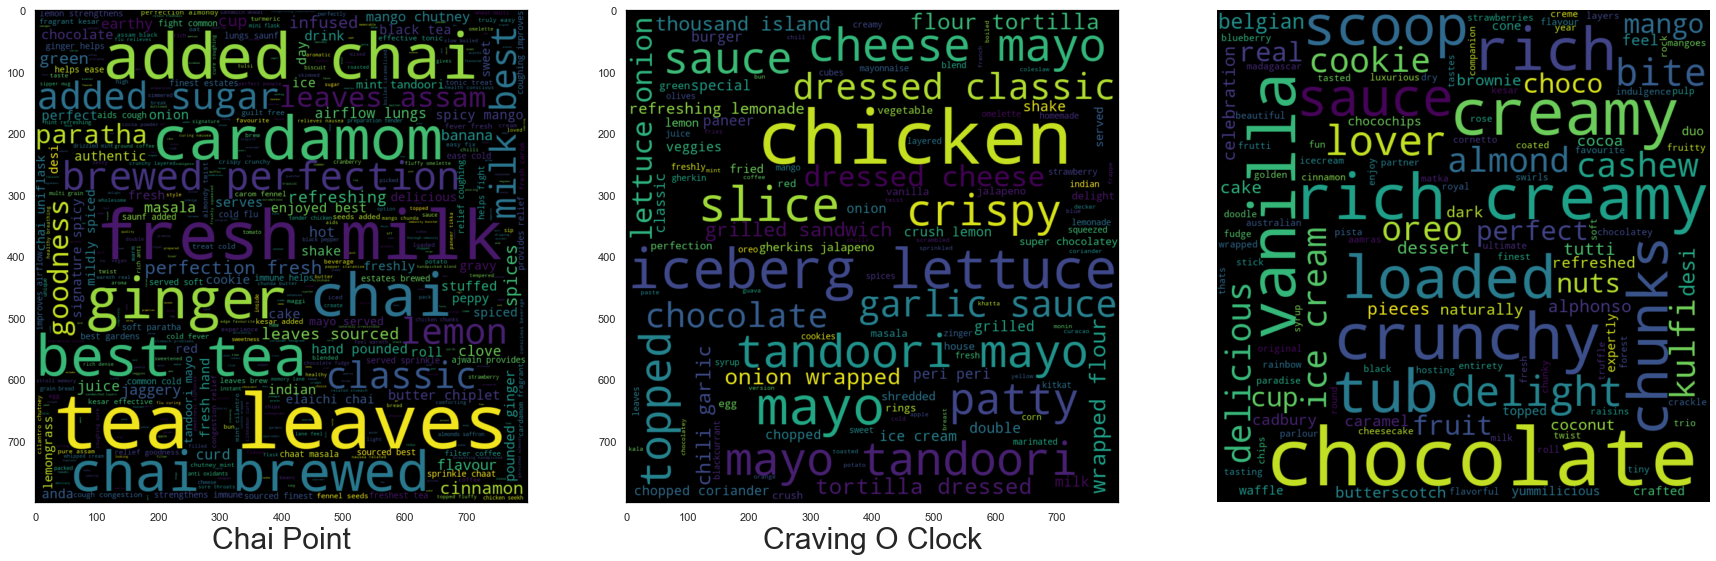

In [12]:
f, ax = plt.subplots(1, 3, figsize = (30, 10))
plt.grid(0)
plt.axis('off')
for i in range(3):
    ax[i].grid(0)
    ax[i].set_xlabel(df.restName.unique()[i], fontsize = 30)
    wc = WordCloud(max_words = 500 , width = 800 , height = 800).generate(" ".join(list(df.itemDescClean.loc[df.restId == i])))
    ax[i].imshow(wc, interpolation = 'bilinear')

## (III) Insights

### 1. Categorical Distribution of Bestsellers

I'll use TF-IDF (Term Frequency-Inverse Document Frequency) to identify the top 3 words in each description. The TF-IDF calculation indicates the importance of a word in a document.

In [13]:
vocab = TfidfVectorizer()
x = vocab.fit_transform(df['itemDescClean']).toarray()
termImp = []
for count, i in enumerate(x):
    # list containing 3-word sets of the most important words in an item description according to TF-IDF
    termImp.append(' '.join([vocab.get_feature_names()[n] for n in np.argsort(i)[-3:]]))
df['termImp'] = termImp

Using the above, I'll use a Word Cloud to visualise the frequency of important words occuring in the descriptions of bestselling items:

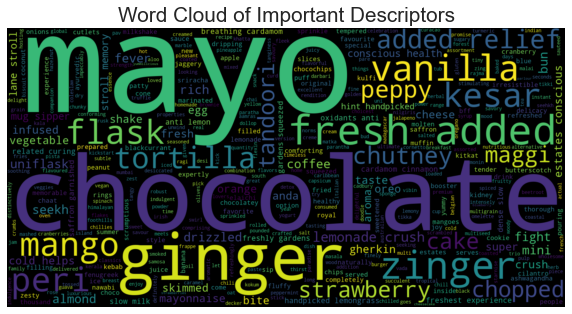

In [14]:
plt.figure(figsize = (10,10)) 
wc = WordCloud(max_words = 500 , width = 1600 , height = 800).generate(" ".join(df.termImp))
plt.grid(0)
plt.axis('off')
plt.title('Word Cloud of Important Descriptors', fontsize = 'xx-large')
plt.imshow(wc, interpolation = 'bilinear')

Some of the top words identified in this word cloud are:

**`mayo`, `chocolate`, `fresh`, `zinger`, `ginger`**.

Now, we visualise the distribution of items (and bestsellers) across categories:

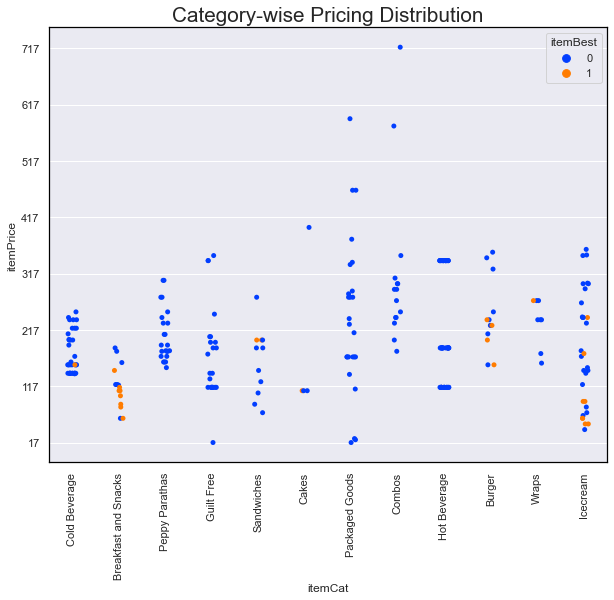

In [15]:
plt.figure(figsize=(10,8))
sns.stripplot(x='itemCat', y='itemPrice', data=df, hue='itemBest', size=5)
plt.xticks(rotation=90)
plt.yticks(np.arange(min(df.itemPrice), max(df.itemPrice), step=100))
plt.title('Category-wise Pricing Distribution', fontsize = 'xx-large')
plt.show()

From the above, it is clear that the bestsellers are found only in some categories. 

We can already see this in the Description Word Cloud because of the occurence of certain words. For instance, we can expect the following relationship between category and description:

* `mayo`: 'Sandwiches' , 'Burgers', and 'Wraps'
* `chocolate`: 'Icecream'
* `fresh`: 'Cold Beverage
* `zinger`: 'Burgers'
* `ginger`: 'Breakfast and Snacks'

We also observe that the bestsellers tend to be priced lower than the others. This is intuitive, and is a good sanity check for the analysis so far.

### 2. Effect of Pricing, Tags, and Menu Size on Customer Base

The Number of Reviews is very likely correlated with the total customer base of a restaurant. Since the star rating is generally favourable for these restaurants, we're likely to expect customer loyalty through returning customers.

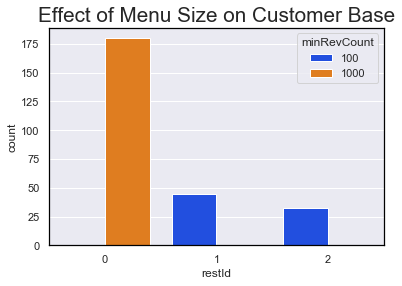

In [16]:
sns.countplot('restId', data = df, hue = 'minRevCount')
plt.title('Effect of Menu Size on Customer Base', fontsize = 'xx-large')
plt.show()

Only Restaurant #0 (`Chai Point`) has 1000+ reviews, while the other 2 fall into the lower bucket. Restaurants with larger menus may thus attract more customers due to them catering to a larger audience.

Next, we look at the effect of Pricing and Tags:

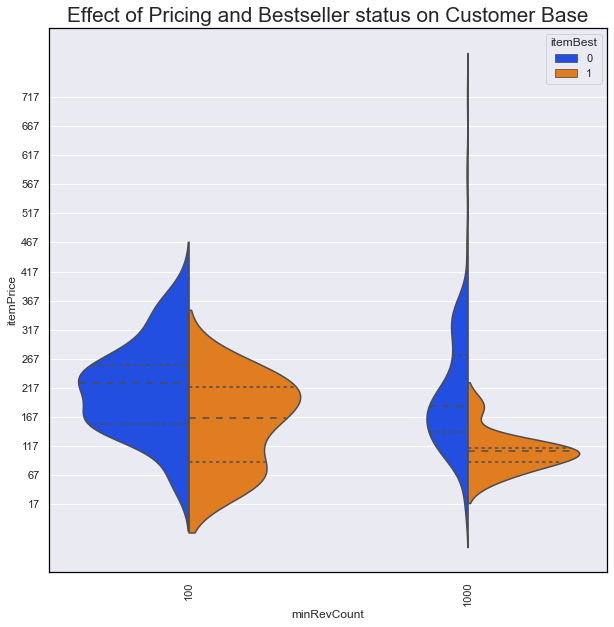

In [17]:
plt.figure(figsize=(10,10))
sns.violinplot(x = 'minRevCount', y='itemPrice', data=df, hue='itemBest', inner = 'quartiles', size = 5, split = True)
plt.xticks(rotation=90)
plt.yticks(np.arange(min(df.itemPrice), max(df.itemPrice), step=50))
plt.title('Effect of Pricing and Bestseller status on Customer Base', fontsize = 'xx-large')
plt.show()

The violinplot on the right clearly shows that restaurants with cheaper bestsellers on average attract a larger audience. The dashed line (`---`) represents the mean of each violin.

Therefore:

* **`Menu Size`** : The larger the menu, the more customers it can serve and the larger the customer base.
* **`Pricing`** : On the whole, lower price items (particularly bestsellers) are more favoured by customers.
* **`Bestsellers`** : The effect of bestsellers is debatable, since the higher preference of bestsellers may both be a cause and an effect (more orders results in items getting bestseller status, and vice-versa). However, the data shows a clear bias for these items.

We observe two peaks in each of the violinplots. For the left one, this may be because the 100+ reviews category contains 2 restaurants, and may have different pricing structures. 

We also see these peaks on the right violinplot, which only represents 1 restaurant. 

### 3. Restaurant-wise Pricing Structure

Here, we can answer the following questions:

* Can a cheaper and balanced menu improve sales?
* We noticed earlier that bestsellers are generally preferred. But are they a reliable indicator of overall high sales?

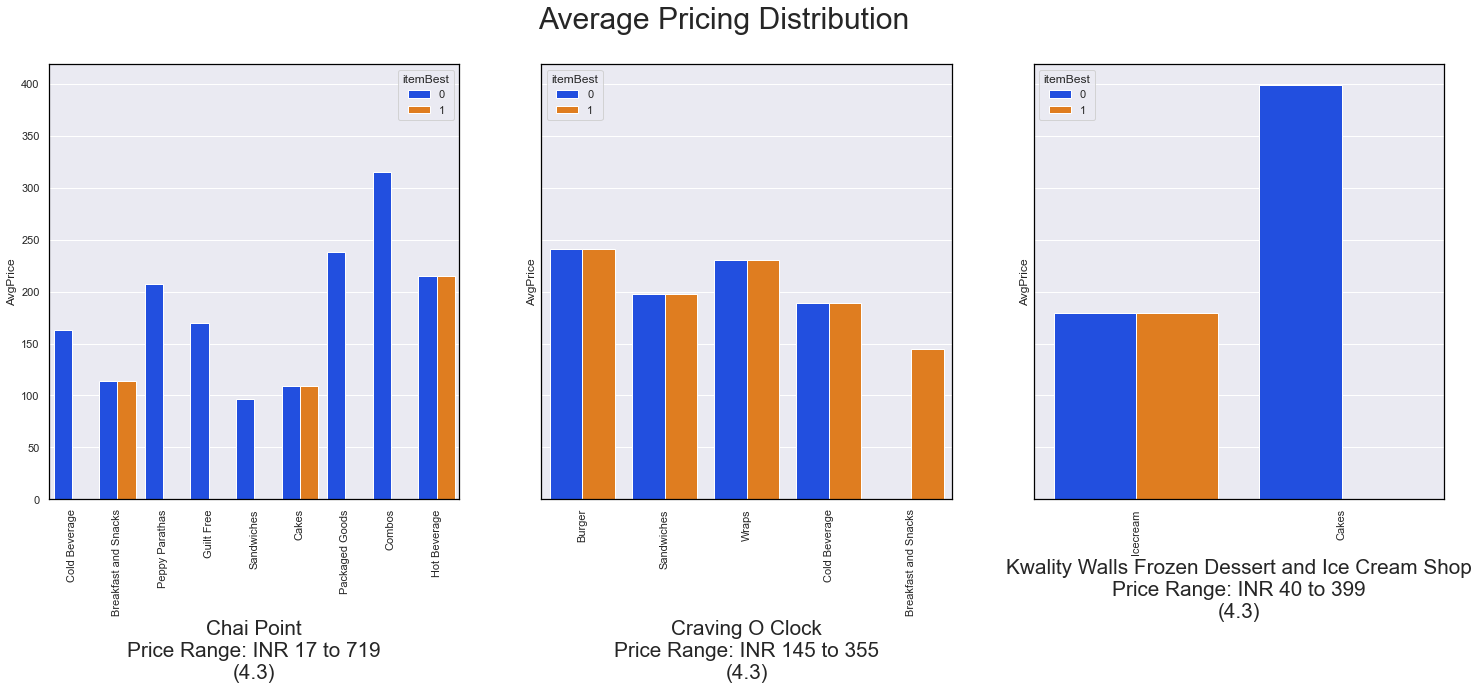

In [18]:
f, ax = plt.subplots(1, 3, sharey = True, figsize = (25, 8))
f.suptitle(t = 'Average Pricing Distribution', fontsize = 30)
for i in range(3):
    cache =  df.loc[(df.restId == i)]
    cache['AvgPrice'] = ''
    cache['MaxPrice'] = ''
    for cat in cache.itemCat.unique():
        catCache = cache.loc[(cache.itemCat == cat), 'itemPrice']
        cache.loc[(cache.itemCat == cat), 'AvgPrice'] = np.mean(catCache)
    sns.barplot(ax = ax[i], x = 'itemCat', y = 'AvgPrice', data = cache, hue = 'itemBest', ci = None)
    ax[i].tick_params(axis = 'x', rotation = 90)
    xText = cache.restName.unique()[0] + '\nPrice Range: INR ' + str(min(cache.itemPrice)) + ' to ' + str(max(cache.itemPrice))
    rating = '('+str(list(cache.restRating)[0])+')'
    ax[i].set_xlabel(xText + '\n' + rating, fontsize = 'xx-large')

`Chai Point` and `Kwality Walls` have a very variable pricing structure between bestsellers and regular offerings, with price ranges of `INR 702` and `INR 359` respectively.

`Craving O Clock` has an overall balanced menu with a range of `INR 210`.

We observe that:

1. Despite having a cheap and balanced menu, `Craving O Clock` has not received as many reviews as `Chai Point`.
2. `Craving O Clock` has bestsellers among all its offered categories. The tag might be calculated based on percentages rather than raw sales.

Thus, we can hypothesize:

1. A well-balanced cheaper menu alone may not be as effective for improving sales.
2. The bestseller tag isn't always a reliable indicator of high sales, especially with a lower order volume.

### 4. Do customers take decisions based on Item Descriptions?

The verbosity of an item's description may reflect the item's quality. Conversely, the length of an item's name might cause buyers to be put off.

In [19]:
# creating columns with name/description length from preprocessed text
descLength = []
nameLength = []
for i in range(len(df)):
    descLength.append(len(df.itemDescClean.loc[i].split(' ')))
    nameLength.append(len(df.itemNameClean.loc[i].split(' ')))
df['descLength'] = pd.Series(descLength)
df['nameLength'] = pd.Series(nameLength)

Text(0.5, 0, 'Description Length')

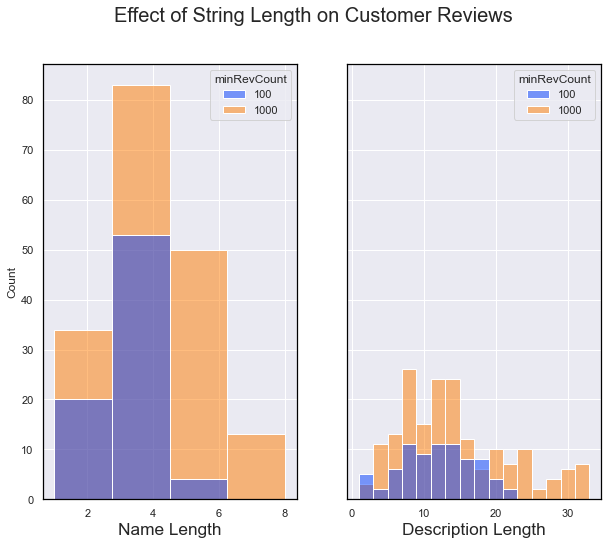

In [20]:
f, ax = plt.subplots(1, 2, sharey = True, figsize = (10, 8))
f.suptitle(t = 'Effect of String Length on Customer Reviews', fontsize = 20)
sns.histplot(ax = ax[0], x='nameLength', data=df, hue='minRevCount', palette = 'bright', bins = 4)
ax[0].set_xlabel('Name Length', fontsize = 'x-large')
sns.histplot(ax = ax[1], x='descLength', data=df, hue='minRevCount', palette = 'bright', bins = 16)
ax[1].set_xlabel('Description Length', fontsize = 'x-large')

**Name** : From the above, items with slightly longer names appear to fare better, since the distribution is slightly transposed to the right.

**Description** : The distribution has a large tail to the right, which indicates that longer descriptions might work in the restaurant's favour.

Text(0.5, 0, 'Name Length')

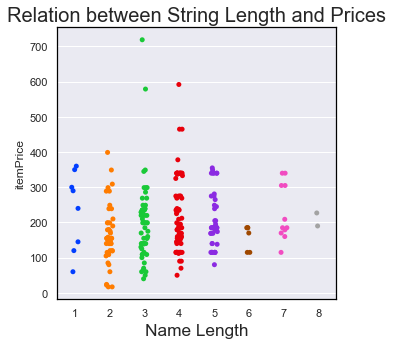

In [21]:
plt.figure(figsize = (5, 5))
plt.title('Relation between String Length and Prices', fontsize = 20)
sns.stripplot(x='nameLength', data=df, y ='itemPrice', palette = 'bright')
plt.xlabel('Name Length', fontsize = 'x-large')

We also observe that there is a slight increasin trend of average prices with increase in item name length. This is more likely a coincidence, but interesting nonetheless.

## Conclusion

We gathered the following insights:

1. Bestselling items are found in a few categories:
    * 'Sandwiches'
    * 'Burgers'
    * 'Wraps'
    * 'Icecream'
    * 'Cold Beverage
    * 'Breakfast and Snacks'

    This is also easily indicated through quick analysis of the item descriptions (refer to the Word Cloud). 

2. Bigger menus are an indicator of a larger customer base. 
3. Restaurants with cheaper bestsellers tend to be those with more customers. 
4. Bestsellers are generally preferred, but they aren't an indicator of overall high sales at a restaurant.
5. According to the dataset, a cheaper and well-balanced menu doesn't necessarily imply more sales.
6. Longer item names tend to belong to restaurants with higher sales. These also tend to be slightly pricier.
7. Items with longer descriptions sell better. This may also imply that people don't read item descriptions or are atleast not negatively influenced by them.

### Storing in .csv for use in Tableau dashboarding

In [22]:
df.to_csv('processedData.csv', index = False)